# Basic Instructions

1. Enter your Name, UID and Link to Google Drive in the provided space.
2. Submit the assignment to Gradescope.

Intermediate Submission Deadline: April 13, 5:00pm

Final Submission Deadline: April 16, 5:00pm

As before, submit your challenge file to ELMS.

Name:  **Siyuan Peng**
UID:  **116243407**

Link to Google Drive : **Link Here (make sure it works)**

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage
from tqdm import tqdm
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

## Dataset and Preprocessing

For this assignment, we will use the following dataset, which contains images of animals and such with segmentations.

In [56]:
#For deleting the dataset
#!rm -r SegmentationDataset/

#Use this to download if not using colab
download_link='https://drive.google.com/file/d/1vDWwIBXcZURKsKwQUhGmFdgqwBhyIaIn/view?usp=sharing'

#If using colab dataset can be downloaded using this command
!gdown --id 1vDWwIBXcZURKsKwQUhGmFdgqwBhyIaIn
!unzip --qq SegmentationDataset.zip

In [57]:
%matplotlib inline
import cv2
import os
import torch.utils.data as data
from torchvision import transforms
import _pickle as pickle
import torchvision.models as models
import glob

current_directory = os.getcwd()
# msrc_directory = current_directory + '/SegmentationDataset'
msrc_directory = 'SegmentationDataset'
os.chdir('E:\Study\cmsc472\CMSC472_hw4')
print(f'Current Directory {os.getcwd()}')
def plot_image(im,title,xticks=[],yticks= [],cv2 = True):
    """
    im :Image to plot
    title : Title of image 
    xticks : List of tick values. Defaults to nothing
    yticks :List of tick values. Defaults to nothing 
    cv2 :Is the image cv2 image? cv2 images are BGR instead of RGB. Default True
    """

    plt.figure()
    if(im.shape[2]==1):
        plt.imshow(np.squeeze(im),cmap='gray')
    elif cv2:
        plt.imshow(im[:,:,::-1])
    else:
        plt.imshow(im)
    plt.title(title)
    plt.xticks(xticks)
    plt.yticks(yticks)
    

Current Directory E:\Study\cmsc472\CMSC472_hw4


In [58]:
# from Dataset_v1
SEG_LABELS_LIST_v1 = [
    {"id": -1, "name": "void",       "rgb_values": [0,   0,    0]},
    {"id": 0,  "name": "building",   "rgb_values": [128, 0,    0]},
    {"id": 1,  "name": "grass",      "rgb_values": [0,   128,  0]},
    {"id": 2,  "name": "tree",       "rgb_values": [128, 128,  0]},
    {"id": 3,  "name": "cow",        "rgb_values": [0,   0,    128]},
    {"id": 4,  "name": "sky",        "rgb_values": [128, 128,  128]},
    {"id": 5,  "name": "airplane",   "rgb_values": [192, 0,    0]},
    {"id": 6, "name": "face",       "rgb_values": [192, 128,  0]},
    {"id": 7, "name": "car",        "rgb_values": [64,  0,    128]},
    {"id": 8, "name": "bicycle",    "rgb_values": [192, 0,    128]}]

background_classes=["void","grass","sky"]
background_colors=[]
for i in range(len(SEG_LABELS_LIST_v1)):
    if SEG_LABELS_LIST_v1[i]["name"] in background_classes:
        background_colors.append(SEG_LABELS_LIST_v1[i]["rgb_values"])



def get_binary_seg(bgr_seg):
    rgb_seg=bgr_seg#[:,:,::-1]#reverse order of channels from bgr to rgb
    shape_rgb=rgb_seg.shape
    binary_shape=(shape_rgb[0],shape_rgb[1],1)

    binary_map=np.ones( binary_shape )
    for background_color in background_colors:
        binary_map[(rgb_seg==background_color).all(2)]=0
    
    return binary_map

Here are some examples.

<class 'numpy.ndarray'>
(213, 320, 3)


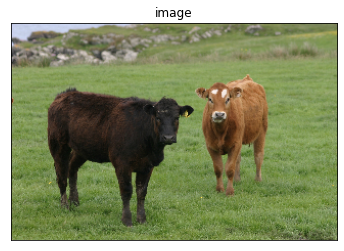

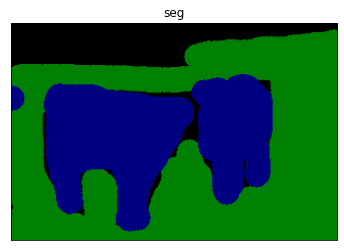

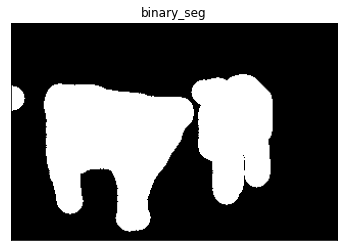

In [59]:
#  plot a sample image and its ground truth segments
image_sample = cv2.imread('SegmentationDataset/train/1_19_s.bmp')
seg_sample = cv2.imread('SegmentationDataset/train/1_19_s_GT.bmp') 
print(type(seg_sample))
print(seg_sample.shape)
plot_image(image_sample, 'image')
plot_image(seg_sample, 'seg')
plot_image(get_binary_seg(seg_sample), 'binary_seg')

Here we provide you with a Dataset and dataloaders.

---



In [60]:
class SegmentationData(data.Dataset):
    #168:48:24 split
    def __init__(self, transform, mode='train'):
        if mode not in ['train','test','val']:
            raise ValueError('Invalid Split %s' % mode)
        self.mode = mode
        self.transform = transform
        self.img_list_train_val = [x.split('.')[-2].split('/')[-1][:-3] for x in glob.glob(msrc_directory+'/train/*') if 'GT' in x]
        self.img_list_train_val.sort()
        self.img_list_test = [x.split('.')[-2].split('/')[-1] for x in glob.glob(msrc_directory+'/test/*')]
        self.img_list_test.sort()

        self.x={}
        self.y={}
        self.x['train'] = ['%s/%s.bmp' %(msrc_directory+'/train',x) for x in self.img_list_train_val[:168]]
        self.y['train'] = ['%s/%s_GT.bmp' %(msrc_directory+'/train',x) for x in self.img_list_train_val[:168]]
        self.x['val'] = ['%s/%s.bmp' %(msrc_directory+'/train',x) for x in self.img_list_train_val[168:]]
        self.y['val'] = ['%s/%s_GT.bmp' %(msrc_directory+'/train',x) for x in self.img_list_train_val[168:]]
        self.x['test'] = ['%s/%s.bmp' %(msrc_directory+'/test',x) for x in self.img_list_test]
        # self.x['train'] = ['%s/%s.bmp' %(msrc_directory,x) for x in self.img_list_train_val[:168]]
        # self.y['train'] = ['%s/%s_GT.bmp' %(msrc_directory,x) for x in self.img_list_train_val[:168]]
        # self.x['val'] = ['%s/%s.bmp' %(msrc_directory,x) for x in self.img_list_train_val[168:]]
        # self.y['val'] = ['%s/%s_GT.bmp' %(msrc_directory,x) for x in self.img_list_train_val[168:]]
        # self.x['test'] = ['%s/%s.bmp' %(msrc_directory,x) for x in self.img_list_test]

    def __len__(self):
        return len(self.x[self.mode])

    def __getitem__(self, index):
      if self.mode in ['train', 'val']:
          img = Image.open(self.x[self.mode][index]).convert('RGB')
          #img = cv2.imread(self.x[self.mode][index]).astype(np.int)
          mask = get_binary_seg(np.array(Image.open(self.y[self.mode][index]).convert('RGB')))#.astype(np.int)
          mask = np.squeeze(mask.astype(np.uint8), axis=2)
          mask = Image.fromarray(mask)
          #mask = cv2.imread(self.y[self.mode][index])
          #if (img.size[0]!=213):
          #    img = img.transpose()
          #    mask = cv2.transpose(mask)
          tensor_img = self.transform(img)
          tensor_mask = self.transform(mask)
          return tensor_img,tensor_mask
      else:
          #img = cv2.imread(self.x[self.mode][index]).astype(np.float32)
          img = Image.open(self.x[self.mode][index]).convert('RGB')
          #if (img.size[0]!=213):
          #    img = cv2.transpose(img)
          tensor_img = self.transform(img)
          return tensor_img


transform = transforms.Compose([transforms.Resize((256,256)),transforms.ToTensor()])
train_set = SegmentationData(transform=transform, mode='train')
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True)
val_set = SegmentationData(transform=transform, mode='val')
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=16, shuffle=False)
test_set = SegmentationData(transform=transform, mode='test')
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=16, shuffle=False)

For convenience, here's an example of how to use these dataloaders.

In [61]:
input,labels = next(iter(train_dataloader))
print(input.shape,labels.shape)
print(type(input[2]))
img = input[2].numpy().transpose(1, 2, 0)
mask = labels[2].numpy().transpose(1, 2, 0)
plot_image(img, 'train_image', cv2=False)
plot_image(mask, 'train_seg')

input,labels = next(iter(val_dataloader))
print(input.shape,labels.shape)
img = input[2].numpy().transpose(1, 2, 0)
mask = labels[2].numpy().transpose(1, 2, 0)
plot_image(img, 'val_image', cv2=False)
plot_image(mask, 'val_seg')

input = next(iter(test_dataloader))
print(input.shape)
img = input[2].numpy().transpose(1, 2, 0)
plot_image(img, 'test_image', cv2=False)

FileNotFoundError: [Errno 2] No such file or directory: 'SegmentationDataset/train/train\\5_16_s.bmp'

## 1. Architecture of your model

Now that you are familiar with the dataset, it is time to build a deep neural network to perform these segmentations, where we need to distinguish foreground from background, where the class of interest is considered foreground.

###  U-Net

<img src="https://www.researchgate.net/profile/Alan-Jackson-2/publication/323597886/figure/fig2/AS:601386504957959@1520393124691/Convolutional-neural-network-CNN-architecture-based-on-UNET-Ronneberger-et-al.png" style="width:650px;height:400px;">

A U-Net is an end-to-end segmentation network that should work reasonably well in this low data setting. It will take an image, progressively convolve it to a collection of many small feature maps, and then progressively up-convolve the maps while combining with crops from the previous layers. The figure provided gives an excellent example of a baseline U-Net that you can use as a starting point.

For these operations, use ```nn.Conv2d```, ```torch.cat```, and ```nn.ConvTranspose2d```, ```nn.MaxPool2d```. You may find it useful to use ```nn.BatchNorm2d``` as well.

Note that you can experiment with different channel sizes. Try to start with something smaller than 112, like 16.

Let's now implement those the model!

In [ ]:
class UNet(nn.Module):
  def __init__(self):
    super(UNet, self).__init__()
    

  def forward(self, input):
    pass


## 2. Defining the for loop for train and validation phase

### In each the phases certain things one has to be careful of:

- Training Phase:
  - Make sure the model is in train mode. That is ensured by `model.train()`

  - While looping over instances of a batch, make sure the graidents are always set to zero before calling the backward function. That's done by `optim.zero_grad()`. If this is not done, the gradients get accumulated.

  - Call the backward function on the loss by `loss.backward()` so that the loss get back propagated.

  - Call the step function of the optimiser to update the weights of the network. This is done by `optim.step()`

- Validation/Testing Phase
  - Make sure your model is in eval mode. This makes the model deterministic rather than probabilistic. This is ensured by `model.eval()`
  - As we don't need any gradients doing our validation/ testing phase, we can esnure that they are not calculated by defining a block with `torch.no_grad()`

In [ ]:
model = UNet()
model = model.cuda()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Run your training / validation loops
num_epochs = 10
for epoch in range(num_epochs):
  model.train()

  with torch.no_grad():
    model.eval()
    

## 3. Challenge Submission
Evaluate on the test set, and save the resulting segmentations in the same format as those in the initial dataset. 
Your challenge results should be saved in a torch file with the same format as in A3, with shape (24, 256, 256), where all values are either 1 (foreground) or 0 (background).

Use this code to check your submission file:

In [ ]:
masks = torch.load('results.pth.tar')

assert(masks.shape == (24, 256, 256))
assert((torch.where(masks == 1, 10, 0).sum() + torch.where(masks == 0, 10, 0).sum()).item() == 24 * 256 * 256 * 10)

## Analysis



### 4. Plot training and validation loss per batch

### 5. Plot training and validation accuracy per epoch

### 6. Show segmentation result for 3 test images

